# Bayesian Optimization with Preference Exploration

In this tutorial, we demonstrate how to implement a closed loop of Bayesian optimization with preference exploration, or BOPE [1].
BOPE is designed for Bayesian optimization of expensive-to-evaluate experiments,
where the response surface function of the experiment $f_\mathrm{true}$ generates vector-valued outcomes over which a decision-maker (DM) has preferences.
These preferences are encoded by a utility function $g_\mathrm{true}$ that is not known in closed form but can be estimated by
asking the DM to express preferences over pairs of outcome vectors.

In other words, with BOPE, we wish to solve the following optimization problem:

$$
 \max_{x \in \mathcal{X}} g_\mathrm{true}(f_\mathrm{true}(x))
$$

Unlike many other Bayesian optimization setups where multiple consecutive batches of experiments are performed,
in BOPE, we alternate between two stages: *preference exploration* and *experimentation*.

In the preference exploration stage, we use an acquisition function (i.e., a preference exploratoin strategy, or PE strategy)
to adaptively generate pairs of hypothetical outcome and ask the decision-maker’s preference within each pair.
In the experimentation stage, we use a batch version of noisy expected improvement that integrates over our uncertainty in the
utility function called $\text{qNEIUU}$ to generate experimental candidates for evaluation.


[1] [Z.J. Lin, R. Astudillo, P.I. Frazier, and E. Bakshy, Preference Exploration for Efficient Bayesian Optimization with Multiple Outcomes. AISTATS, 2022.](https://arxiv.org/abs/2203.11382)

In [1]:
import os

import matplotlib as mpl
import matplotlib.pylab as plt
import pandas as pd
import torch
from botorch.acquisition import GenericMCObjective, LearnedObjective
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement, qSimpleRegret
from botorch.acquisition.preference import AnalyticExpectedUtilityOfBestOption
from botorch.fit import fit_gpytorch_model
from botorch.models.deterministic import FixedSingleSampleModel
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.optim.optimize import optimize_acqf
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.test_functions.multi_objective import DTLZ2
from botorch.utils.sampling import draw_sobol_samples
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


# Set plotting colors
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=colors)

SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Problem Setup

In this tutorial, we use the DTLZ2 problem with d=6 inputs and k=4 outcomes as our test problem $f_\mathrm{true}$.

For the utility function $g_\mathrm{true}$, we use the negative L1 distance from a Pareto-optimal point the outcome space:
$Y^* = f(X^*)$ where $X^* = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]$. 

In [2]:
def neg_l1_dist(Y):
    """Negative L1 distance from a Pareto optimal points"""
    if len(Y.shape) == 1:
        Y = Y.unsqueeze(0)
    dist = torch.cdist(Y, torch.full(Y.shape[-1:], fill_value=0.5).unsqueeze(0), p=1).squeeze(-1)
    return -dist


if SMOKE_TEST:
    NUM_RESTARTS = 2
    NUM_SMAPLES = 8
    RAW_SAMPLES = 4
    BATCH_LIMIT = 2
else:
    NUM_RESTARTS = 16
    NUM_SMAPLES = 128
    RAW_SAMPLES = 128
    BATCH_LIMIT = 4

X_dim = 6
Y_dim = 4
problem = DTLZ2(dim=X_dim, num_objectives=Y_dim)
util_func = neg_l1_dist

Here we define a collection of helper functions for BOPE:

In [3]:
def fit_outcome_model(X, Y, X_bounds):
    """Fit the outcome model f"""
    outcome_model = SingleTaskGP(train_X=X, train_Y=Y)
    mll = ExactMarginalLogLikelihood(outcome_model.likelihood, outcome_model)
    fit_gpytorch_model(mll)
    return outcome_model


def fit_pref_model(Y, comps):
    """Fit the preference model g"""
    model = PairwiseGP(Y, comps, jitter=1e-4)
    mll = PairwiseLaplaceMarginalLogLikelihood(model)
    fit_gpytorch_model(mll)
    return model


def gen_rand_X(problem, n):
    """Generate n quasi-random Sobol points in the design space"""
    return draw_sobol_samples(bounds=problem.bounds, n=1, q=n).squeeze(0)


def generate_random_exp_data(problem, n):
    """Generate n observations of (X, Y) Pairs"""
    X = gen_rand_X(problem, n)
    Y = problem(X)
    return X, Y


def generate_random_pref_data(outcome_model, n):
    """Generate n pairwise comparison data between 2n points"""
    X = gen_rand_X(problem, 2 * n)
    Y = outcome_model.posterior(X).sample().squeeze(0)
    util = util_func(Y)
    comps = gen_comps(util)
    return Y, comps


def gen_comps(util):
    """Given an 1-d tensor of utility, create pairwise comparisons between adjacent items"""
    util = util.reshape(-1, 2)
    comps = torch.arange(util.numel()).reshape(-1, 2)
    flip = util[:, 0] < util[:, 1]
    comps[flip, [0]], comps[flip, [1]] = comps[flip, [1]], comps[flip, [0]]

    return comps


def gen_exp_cand(outcome_model, objective, q, acqf_name):
    """Given an outcome model and an objective, generate q experimental candidates
    using specified acquisition function."""
    sampler = SobolQMCNormalSampler(num_samples=NUM_SMAPLES)
    if acqf_name == "qNEI":
        # generate experimental candidates with qNEI/qNEIUU
        acq_func = qNoisyExpectedImprovement(
            model=outcome_model,
            objective=objective,
            X_baseline=X,
            sampler=sampler,
            prune_baseline=True,
        )
    elif acqf_name == "posterior_mean":
        # generate experimental candidates with maximum posterior mean
        acq_func = qSimpleRegret(
            model=outcome_model,
            sampler=sampler,
            objective=objective,
        )
    else:
        raise RuntimeError("Unknown acquisition function name!")

    # optimize the acqf
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        q=q,
        bounds=problem.bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={"batch_limit": BATCH_LIMIT},
        sequential=True,
    )
    return candidates


def run_pref_learn(outcome_model, train_Y, train_comps, n_comps, pe_strategy):
    """Perform preference exploration with a given PE strategy for n_comps rounds"""
    for i in range(n_comps):
        print(f"Running {i+1}/{n_comps} preference learning using {pe_strategy}")
        pref_model = fit_pref_model(train_Y, train_comps)

        if pe_strategy == "EUBO-zeta":
            # EUBO-zeta
            one_sample_outcome_model = FixedSingleSampleModel(model=outcome_model)
            acqf = AnalyticExpectedUtilityOfBestOption(pref_model=pref_model, outcome_model=one_sample_outcome_model)

            cand_X, acqf_val = optimize_acqf(
                acq_function=acqf,
                q=2,
                bounds=problem.bounds,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,  # used for intialization heuristic
                options={"batch_limit": BATCH_LIMIT},
            )
            cand_Y = one_sample_outcome_model(cand_X)
        elif pe_strategy == "Random-f":
            # Random-f
            cand_X = gen_rand_X(problem, n=2)
            cand_Y = outcome_model.posterior(cand_X).sample().squeeze(0)
        else:
            raise RuntimeError("Unknown preference exploration strategy!")

        cand_Y = cand_Y.detach().clone()
        cand_comps = gen_comps(util_func(cand_Y))

        train_comps = torch.cat((train_comps, cand_comps + train_Y.shape[0]))
        train_Y = torch.cat((train_Y, cand_Y))

    return train_Y, train_comps


def find_max_posterior_mean(outcome_model, train_Y, train_comps):
    """Helper function that find the max posterior mean under current outcome and
    preference model"""
    pref_model = fit_pref_model(train_Y, train_comps)
    pref_obj = LearnedObjective(pref_model=pref_model)
    post_mean_cand_X = gen_exp_cand(outcome_model, pref_obj, q=1, acqf_name="posterior_mean")

    post_mean_util = util_func(problem(post_mean_cand_X)).item()
    print(f"Max posterior mean utility: {post_mean_util:.3f}")
    within_result = {
        "n_comps": train_comps.shape[0],
        "util": post_mean_util,
    }
    return within_result

## Closed Loop BOPE

### Setup
The following cell shows the core part of this tutorial.
In BOPE, we use two probablistic models (in this case, two Gaussian processes) $f$ and $g$
to model $f_\mathrm{true}$ and $g_\mathrm{true}$ respectively.

We start by initializing the outcome model $f$ with 16 quasi-random points (the initial experimentation stage).

Next, we enter the preference exploration (PE) stage.
A straightforward strategy of performing PE is to present the decision-maker with comparisons using outcomes estimated
by sampling from the outcome model using random design points. We refer this method as $\text{Random}\mathrm{-}f$.

Alternatively, we could initialize the preference model with $\text{Random}\mathrm{-}f$,
then perform PE using the $\text{EUBO}\mathrm{-}\zeta$ acquisition function as proposed in [1].
<!-- \tilde{f} somehow is not rendering --> 

In this tutorial, we examine both strategies by starting with initializating the preference model with 2k=8 comparisons using $\text{Random}\mathrm{-}f$.
After that, we perform 20 pairwise comparisons using either $\text{EUBO}\mathrm{-}\zeta$ or $\text{Random}\mathrm{-}f$.
Then we move on to the 2nd experimentation stage by generating a candidate using qNEIUU by
leveraging both the outcome model and the learned preference model.

We additionally examine two other experimental canadidate generation strategies:
In the first one, we assume the true utility function is known and generate experiment candidate(s) using qNEI.
This represents the performance upper bound of PE strategies.
For the second experiment canadidate generation strategy, we use random design points to generate new candidates.

In [4]:
verbose = False
every_n_comps = 5
n_check_post_mean = 4
n_reps = 2 if SMOKE_TEST else 30
within_session_results = []
exp_candidate_results = []

for i in range(n_reps):
    print(f"Run {i}")
    # Experimentation stage: initial exploration batch
    torch.manual_seed(i)
    X, Y = generate_random_exp_data(problem, 16)
    outcome_model = fit_outcome_model(X, Y, problem.bounds)

    # Preference exploration stage: initialize the preference model with comparsions
    # between pairs of outcomes estimated using random design points
    init_train_Y, init_train_comps = generate_random_pref_data(outcome_model, n=2 * Y_dim)

    # Perform preference exploration using either Random-f or EUBO-zeta
    for pe_strategy in ["Random-f", "EUBO-zeta"]:
        train_Y, train_comps = init_train_Y, init_train_comps
        within_result = find_max_posterior_mean(outcome_model, train_Y, train_comps)
        within_result.update({"run_id": i, "pe_strategy": pe_strategy})
        within_session_results.append(within_result)

        for j in range(n_check_post_mean):
            train_Y, train_comps = run_pref_learn(
                outcome_model, train_Y, train_comps, n_comps=every_n_comps, pe_strategy=pe_strategy
            )
            if verbose:
                print(f"Checking posterior mean after {(j+1) * every_n_comps} comps using PE strategy {pe_strategy}")
            within_result = find_max_posterior_mean(outcome_model, train_Y, train_comps)
            within_result.update({"run_id": i, "pe_strategy": pe_strategy})
            within_session_results.append(within_result)

        # Going back to the experimentation stage: generate an additional batch of experimental evaluations
        # with the learned preference model and qNEIUU
        pref_model = fit_pref_model(train_Y, train_comps)
        pref_obj = LearnedObjective(pref_model=pref_model)
        exp_cand_X = gen_exp_cand(outcome_model, pref_obj, q=1, acqf_name="qNEI")
        qneiuu_util = util_func(problem(exp_cand_X)).item()
        if verbose:
            print(f"qNEIUU candidate utility: {qneiuu_util:.3f}")
        exp_result = {
            "util": qneiuu_util,
            "strategy": pe_strategy,
            "run_id": i,
        }
        exp_candidate_results.append(exp_result)

    # Generate a batch of experimental evaluations using oracle and random baselines
    # True utility
    true_obj = GenericMCObjective(util_func)
    true_obj_cand_X = gen_exp_cand(outcome_model, true_obj, q=1, acqf_name="qNEI")
    true_obj_util = util_func(problem(true_obj_cand_X)).item()
    if verbose:
        print(f"True objective utility: {true_obj_util:.3f}")
    exp_result = {
        "util": true_obj_util,
        "strategy": "True Utility",
        "run_id": i,
    }
    exp_candidate_results.append(exp_result)

    # Random experiment
    _, random_Y = generate_random_exp_data(problem, 1)
    random_util = util_func(random_Y).item()
    if verbose:
        print(f"Random experiment utility: {random_util:.3f}")
    exp_result = {
        "util": random_util,
        "strategy": "Random Experiment",
        "run_id": i,
    }
    exp_candidate_results.append(exp_result)

## Plot the Results

We evaluate our results by creating two plots.

In the first plot, we focus on comparing how $\text{EUBO}\mathrm{-}\zeta$ can efficiently identify the maximizer 
of $g_\mathrm{true}(f_\mathrm{true}(x))$ within a preference exploration stage.
We examine this by estimatig the maximum posterior mean after every 5 pairwise comparisons.

Here, we plot the the max utility value identified using $\text{EUBO}\mathrm{-}\zeta$ and $\text{Random}\mathrm{-}f$
with increasing number of pairwise comparisons.
As we can see in this plot, the preference model learned using $\text{EUBO}\mathrm{-}\zeta$ is able to identify the maximum utility more efficiently.

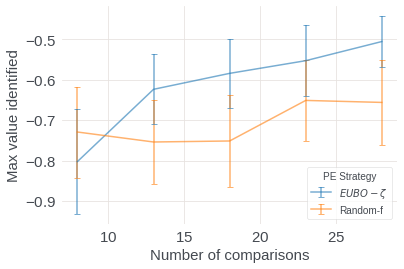

In [5]:
# Prepare PE data for plots
within_df = pd.DataFrame(within_session_results)
within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
within_df = (
    within_df.groupby(["n_comps", "pe_strategy"])
    .agg({"util": ["mean", "sem"]})
    .droplevel(level=0, axis=1)
    .reset_index()
)
within_df

# Plotting
plt.figure(figsize=(6, 4))
for name, group in within_df.groupby("pe_strategy", sort=True):
    plt.errorbar(
        x=group["n_comps"], y=group["mean"], yerr=1.96 * group["sem"], label=name, linewidth=1.5, capsize=3, alpha=0.6
    )
plt.xlabel("Number of comparisons")
plt.ylabel("Max value identified")
plt.legend(title="PE Strategy")

In the following cell, we show the box plot of utility values achieved using different methods in the 2nd experimentation stage.

We see that $\text{EUBO}\mathrm{-}\zeta$, as a one-step Bayesian optimal PE strategy, performs very similarly to the true utility strategy.

On the other hand, despite that $\text{Random}\mathrm{-}f$ is a relatively straightforward PE strategy,
it is still able to suggest experimental candidates with generally higher utility values than the random experiment baseline,
demonstrating the efficacy of the BOPE framework.

Text(0, 0.5, 'Utility achieved in the 2nd experiment stage')

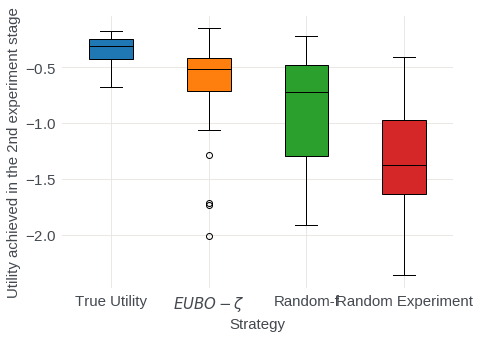

In [6]:
# Prepare the 2nd experimentation batch data for plot
exp_df = pd.DataFrame(exp_candidate_results)
exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
exp_df["strategy"] = pd.Categorical(
    exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
)
bp_data = []
labels = []
for name, group in exp_df.groupby("strategy", sort=True):
    bp_data.append(group["util"])
    labels.append(name)

# Plotting
plt.figure(figsize=(7, 5))
bp = plt.boxplot(bp_data, labels=labels, patch_artist=True)
for median in bp["medians"]:
    median.set_color("black")
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

plt.xlabel("Strategy")
plt.ylabel("Utility achieved in the 2nd experiment stage")